### Библиотеки

In [237]:
!pip install nltk pymorphy2 razdel

In [238]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re
from razdel import tokenize
import pymorphy2
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

### Предобработка данных

In [239]:
# Загрузка данных
df1 = pd.read_csv('/content/Телепрограмма на 10 декабря — Екатеринбург.csv')
df2 = pd.read_csv('/content/Телепрограмма на 11 декабря — Екатеринбург.csv')
df3 = pd.read_csv('/content/Телепрограмма на 12 декабря — Екатеринбург.csv')
df4 = pd.read_csv('/content/Телепрограмма на 13 декабря — Екатеринбург.csv')
df5 = pd.read_csv('/content/Телепрограмма на 14 декабря — Екатеринбург.csv')
df6 = pd.read_csv('/content/Телепрограмма на 15 декабря — Екатеринбург.csv')
df7 = pd.read_csv('/content/Телепрограмма на 16 декабря — Екатеринбург.csv')

# Объединение всех DataFrame в один
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

In [240]:
df.head()

,Channel,Time,Program,Year Release,Description,Age Limit,Rating,Number of Ratings,Categories,Presenters
0,Первый канал,['05:00'],"Телеканал ""Доброе утро""",1986 — по н.в.,Утренняя информационно-развлекательная програм...,0+,6.7,435 оценок,['развлекательное'],"['Лариса Вербицкая', 'Борис Щербаков', 'Екатер..."
1,Первый канал,['09:05'],Модный приговор,2007 — по н.в.,Одно из первых на российском телевидении ток-ш...,0+,4.6,7 262 оценки,['ток-шоу'],"['Александр Рогов', 'Лилия Рах', 'Эвелина Хром..."
2,Первый канал,['09:55'],Жить здорово!,2010 — по н.в.,"Познавательная передача о здоровой, радостной ...",16+,3.7,5 612 оценок,['ток-шоу'],"['Елена Малышева', 'Дмитрий Шубин', 'Андрей Пр..."
3,Первый канал,"['10:45', '19:00']",Время покажет,2014 — по н.в.,Темами каждого выпуска программы являются самы...,16+,4.7,2 119 оценок,['аналитическое'],"['Руслан Осташко', 'Олеся Лосева', 'Екатерина ..."
4,Первый канал,"['14:15', '16:00']",Большая игра,2018 — по н.в.,"Ежедневное ток-шоу, в котором сталкиваются две...",16+,6.1,604 оценки,['ток-шоу'],"['Вячеслав Никонов', 'Дмитрий Саймс']"


In [241]:
# Функция для извлечения года
def extract_year(value):
    # Используем регулярное выражение для извлечения года
    match = re.search(r'\d{4}', value)
    if match:
        return int(match.group(0))
    else:
        return None  # Возвращаем None, если год не найден

# Преобразование данных
df['Year Release'] = df['Year Release'].apply(extract_year)
df['Number of Ratings'] = df['Number of Ratings'].apply(lambda x: int(x.split()[0].replace(' ', '')))
df['Rating'] = df['Rating'].astype(float)

In [242]:
df

,Channel,Time,Program,Year Release,Description,Age Limit,Rating,Number of Ratings,Categories,Presenters
0,Первый канал,['05:00'],"Телеканал ""Доброе утро""",1986,Утренняя информационно-развлекательная програм...,0+,6.7,435,['развлекательное'],"['Лариса Вербицкая', 'Борис Щербаков', 'Екатер..."
1,Первый канал,['09:05'],Модный приговор,2007,Одно из первых на российском телевидении ток-ш...,0+,4.6,7,['ток-шоу'],"['Александр Рогов', 'Лилия Рах', 'Эвелина Хром..."
2,Первый канал,['09:55'],Жить здорово!,2010,"Познавательная передача о здоровой, радостной ...",16+,3.7,5,['ток-шоу'],"['Елена Малышева', 'Дмитрий Шубин', 'Андрей Пр..."
3,Первый канал,"['10:45', '19:00']",Время покажет,2014,Темами каждого выпуска программы являются самы...,16+,4.7,2,['аналитическое'],"['Руслан Осташко', 'Олеся Лосева', 'Екатерина ..."
4,Первый канал,"['14:15', '16:00']",Большая игра,2018,"Ежедневное ток-шоу, в котором сталкиваются две...",16+,6.1,604,['ток-шоу'],"['Вячеслав Никонов', 'Дмитрий Саймс']"
...,...,...,...,...,...,...,...,...,...,...
811,СТС Love,"['10:15', '10:48', '11:21', '11:54', '12:27', ...","Отель ""Элеон""",2016,Действие комедийного сериала развивается в рос...,16+,7.3,5,['комедия'],"['Антон Федотов', 'Антон Маслов']"
812,СТС Love,"['15:45', '16:10', '16:36', '17:02', '17:27', ...",Воронины,2009,Ничем не примечательная семейная пара растит д...,18+,5.8,15,['комедия'],"['Александр Жигалкин', 'Артем Логинов']"
813,СТС Love,"['23:00', '23:25', '23:50', '00:15', '00:40', ...",Дылды,2019,"Главный герой сериала — успешный тренер, секси...",16+,7.1,2,['комедия'],['Сергей Сенцов']
814,СТС Love,"['01:30', '01:53', '02:16']",Папины дочки,2007,"Практикующего психотерапевта, эксперта в семей...",12+,6.3,11,['комедия'],"['Ирина Васильева', 'Александр Жигалкин', 'Кар..."


In [243]:
# Преобразование времени
df['Time'] = df['Time'].apply(lambda x: eval(x))

# Предобработка ограничения по возрасту
df['Age Limit'] = df['Age Limit'].str.replace('+', '').astype(int)

In [244]:
df.head()

,Channel,Time,Program,Year Release,Description,Age Limit,Rating,Number of Ratings,Categories,Presenters
0,Первый канал,[05:00],"Телеканал ""Доброе утро""",1986,Утренняя информационно-развлекательная програм...,0,6.7,435,['развлекательное'],"['Лариса Вербицкая', 'Борис Щербаков', 'Екатер..."
1,Первый канал,[09:05],Модный приговор,2007,Одно из первых на российском телевидении ток-ш...,0,4.6,7,['ток-шоу'],"['Александр Рогов', 'Лилия Рах', 'Эвелина Хром..."
2,Первый канал,[09:55],Жить здорово!,2010,"Познавательная передача о здоровой, радостной ...",16,3.7,5,['ток-шоу'],"['Елена Малышева', 'Дмитрий Шубин', 'Андрей Пр..."
3,Первый канал,"[10:45, 19:00]",Время покажет,2014,Темами каждого выпуска программы являются самы...,16,4.7,2,['аналитическое'],"['Руслан Осташко', 'Олеся Лосева', 'Екатерина ..."
4,Первый канал,"[14:15, 16:00]",Большая игра,2018,"Ежедневное ток-шоу, в котором сталкиваются две...",16,6.1,604,['ток-шоу'],"['Вячеслав Никонов', 'Дмитрий Саймс']"


In [245]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def extract_keywords(description):
    # Токенизация текста с помощью razdel
    words = [token.text for token in tokenize(description.lower())]

    # Удаление стоп-слов и лемматизация
    keywords = [morph.parse(word)[0].normal_form for word in words if word.isalnum() and word not in stop_words]

    return keywords

df['Keywords'] = df['Description'].apply(extract_keywords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Модель

In [246]:
# Определяем числовые и категориальные признаки
numeric_features = ['Age Limit', 'Number of Ratings']
categorical_features = ['Channel', 'Program', 'Categories', 'Presenters', 'Keywords']

# Преобразуем столбцы, содержащие списки, в строки
for col in categorical_features:
    df[col] = df[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Создаем трансформеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем трансформеры в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Целевая переменная
y = df['Rating']

# Признаки (удаляем целевую переменную из набора данных)
X = df.drop('Rating', axis=1)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем и обучаем модель
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', Ridge())])

model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_test)

# Метрики оценки
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Среднеквадратичная ошибка (MSE): {mse}')
print(f'Средняя абсолютная ошибка (MAE): {mae}')
print(f'Коэффициент детерминации (R²): {r2}')

Среднеквадратичная ошибка (MSE): 0.32222286684860857
Средняя абсолютная ошибка (MAE): 0.3159806528693812
Коэффициент детерминации (R²): 0.800830912960651


In [247]:
# Предсказание рейтингов для всех передач в тестовом наборе данных
y_pred_all = model.predict(X)

# Добавляем предсказанные рейтинги в DataFrame
df['Predicted Rating'] = y_pred_all

# Группируем по каналам и вычисляем средний предсказанный рейтинг
channel_avg_predicted_ratings = df.groupby('Channel')['Predicted Rating'].mean().reset_index()

# Группируем по каналам и вычисляем средний актуальный рейтинг
channel_avg_actual_ratings = df.groupby('Channel')['Rating'].mean().reset_index()

# Объединяем предсказанные и актуальные рейтинги в один DataFrame
channel_avg_ratings = channel_avg_actual_ratings.merge(channel_avg_predicted_ratings, on='Channel')

# Сортируем по среднему предсказанному рейтингу
channel_avg_ratings = channel_avg_ratings.sort_values(by='Predicted Rating', ascending=False)

channel_avg_ratings

,Channel,Rating,Predicted Rating
10,Пятница!,7.821429,7.766567
3,Звезда,7.576471,7.548048
5,Культура,7.418750,7.438402
16,Суббота!,7.210811,7.218406
0,2x2,7.175676,7.189410
8,ОТР,7.075000,7.168044
1,5 канал,7.040000,7.029715
19,ТНТ,6.940000,6.947033
14,СТС,6.914286,6.917601
4,Карусель,6.912195,6.915928


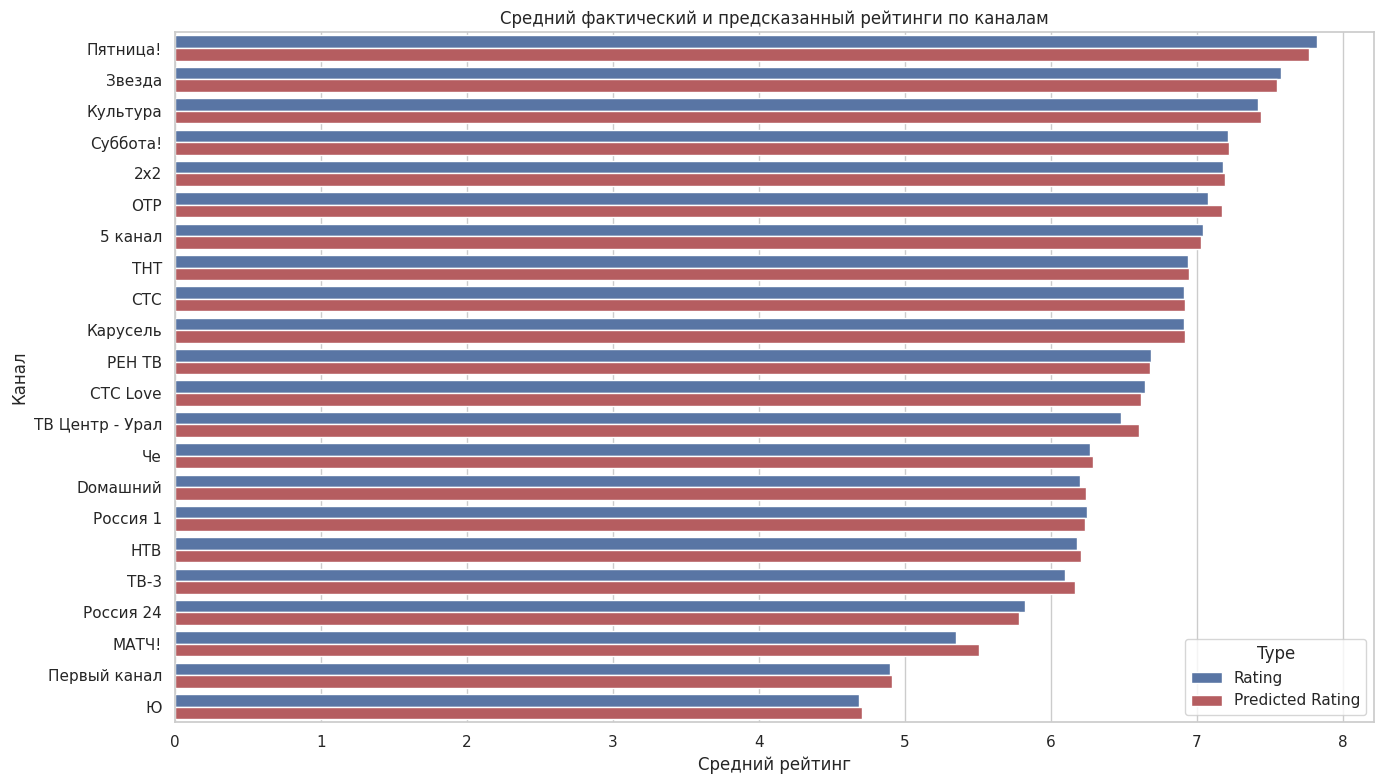

In [248]:
# Устанавливаем стиль Seaborn
sns.set(style="whitegrid")

# Создаем фигуру и оси
plt.figure(figsize=(14, 8))

# Создаем новый DataFrame для построения
melted_ratings = channel_avg_ratings.melt(id_vars='Channel', value_vars=['Rating', 'Predicted Rating'],
                                          var_name='Type', value_name='Average Rating')

# Горизонтальная столбчатая диаграмма
sns.barplot(y='Channel', x='Average Rating', hue='Type', data=melted_ratings, palette=['b', 'r'], orient='h')

# Добавляем заголовок и метки осей
plt.title('Средний фактический и предсказанный рейтинги по каналам')
plt.xlabel('Средний рейтинг')
plt.ylabel('Канал')

# График
plt.tight_layout()
plt.show()

### Feature importance

In [250]:
# Извлечение коэффициентов из модели
coefficients = model.named_steps['regressor'].coef_

# Получение имен признаков: числовые + категориальные (после one-hot кодирования)
feature_names = numeric_features + list(
    model.named_steps['preprocessor'].transformers_[1][1]
    .named_steps['onehot'].get_feature_names_out(categorical_features))

# Создание DataFrame для отображения важности признаков
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

feature_importance['Importance'] = feature_importance['Importance'].abs()
feature_importance

,Feature,Importance
0,Age Limit,0.172348
1,Number of Ratings,0.072351
2,Channel_2x2,0.430383
3,Channel_5 канал,0.300622
4,Channel_Dомашний,0.159040
...,...,...
976,"Keywords_экранизация, пьеса, н, островский, бе...",0.022966
977,"Keywords_это, рассказ, происходить, тварь, пер...",0.082488
978,"Keywords_юмористический, мультфильм, советский...",0.280553
979,"Keywords_юный, волшебница, род, чародей, варя,...",0.021556


In [251]:
# Словарь для хранения важности изначальных признаков
original_feature_importance = {}

# Обработка числовых признаков
for feature in numeric_features:
    original_feature_importance[feature] = feature_importance.loc[feature_importance['Feature'] == feature, 'Importance'].sum()

# Обработка категориальных признаков
for feature in categorical_features:
    # Найти все one-hot закодированные версии этого признака
    one_hot_features = feature_importance[feature_importance['Feature'].str.startswith(feature + '_')]
    # Суммировать их важности
    original_feature_importance[feature] = one_hot_features['Importance'].sum()

original_feature_importance

{'Age Limit': 0.17234755299639093,
 'Number of Ratings': 0.07235116239880557,
 'Channel': 6.639320734627546,
 'Program': 55.00462626456046,
 'Categories': 7.640596065676598,
 'Presenters': 50.96038819300975,
 'Keywords': 55.00462626456046}

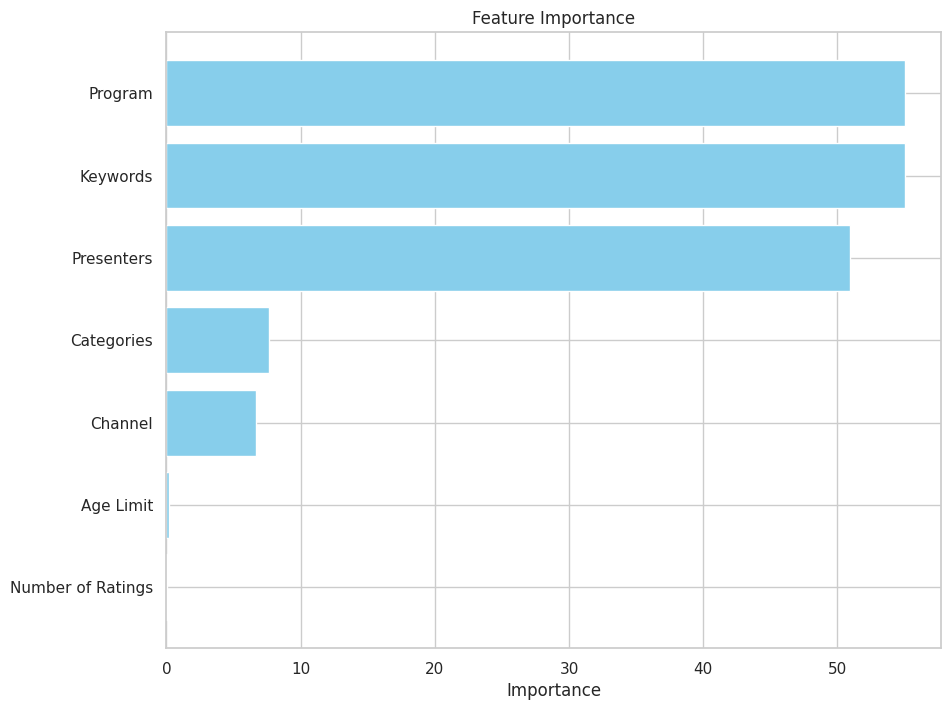

In [252]:
import matplotlib.pyplot as plt

# Сортируем признаки по важности
sorted_features = sorted(original_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Разделяем признаки и их важности для построения графика
features, importances = zip(*sorted_features)

# Создаем график
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы наиболее важные признаки были сверху
plt.show()